<a href="https://colab.research.google.com/github/dukegris/jupyter/blob/master/ibex01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import date
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pandas_datareader as data_reader
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

#S_TICKET = "TEF.MC"
S_TICKET = "SAN.MC"
N_EPOCH = 50
N_DAYS = 10

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## --------------------------------------------------------------------

In [0]:
def create_model_lstm(sequence_length, 
                 units=256, 
                 cell=LSTM, 
                 n_layers=2, 
                 dropout=0.3,
                 loss="mean_absolute_error", 
                 optimizer="rmsprop",
                 bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    model.summary()
    return model

In [0]:
def create_model_ff(n_vars, n_days):
    model = Sequential() 
    model.add(Dense(n_days, input_shape=(1, (n_vars * n_days)), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=["mse"])
    model.summary()
    return model

In [0]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [0]:
# Hacemos que cada fila contenga los ultimos 10 valores de cada una de las variables
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

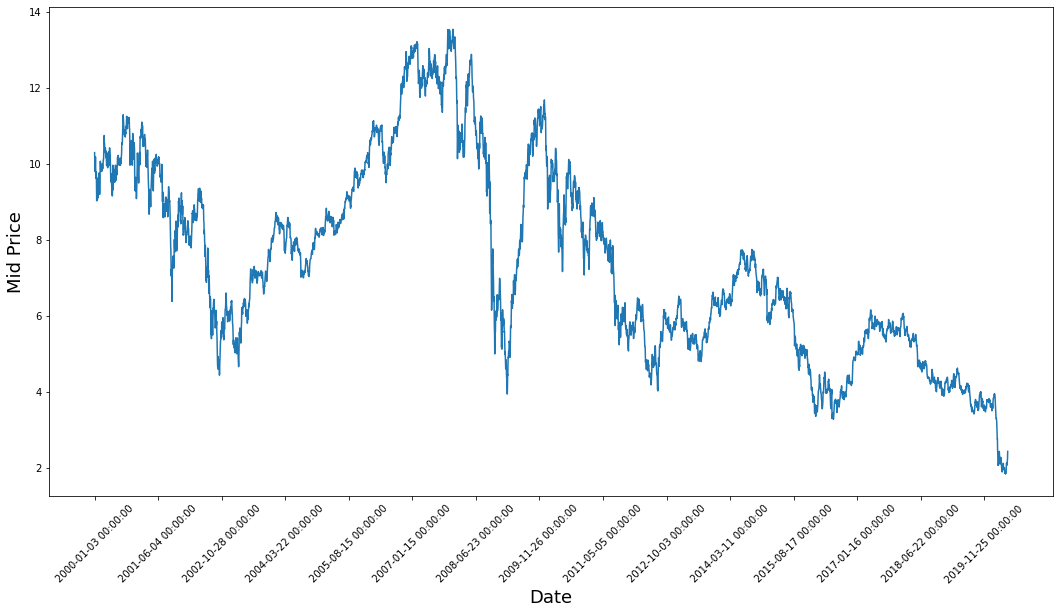

In [0]:
df = data_reader.DataReader(S_TICKET, 
                            start='1980-1-1', 
                            end=date.today(), 
                            data_source='yahoo')
#df[['High','Low', 'Volume', 'Adj Close', 'Open', 'Close']].plot(title='AAPL Data')
#df[['High','Low', 'Adj Close', 'Open', 'Close']].plot(title='AAPL Data')
#df.head()
# Llevamos los valores a -1 - 1 para igualar variables
scaler = MinMaxScaler(feature_range=(-1, 1))
#df_scaled = scaler.fit_transform(df[['High','Low', 'Volume', 'Adj Close', 'Open', 'Close']]
df_scaled = pd.DataFrame(scaler.fit_transform(df[['High','Low', 'Volume', 'Adj Close', 'Open', 'Close']]))
#df_scaled.head()

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],365),df.index[::365], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
N_VARS = 1 if type(df) is list else df.shape[1]
df_reframed = series_to_supervised(df_scaled, N_DAYS, 1, False)
df_reframed.index = df.index
#df_reframed.head()

In [0]:
test_size = df_reframed.shape[0] * .20
n_test_days = int(test_size)
train_size = (df_reframed.shape[0] - n_test_days) * .75
n_train_days = int(train_size)
n_val_days = df_reframed.shape[0] - n_train_days - n_test_days

# prepare train datasets
values = df_reframed.values
train = values[N_DAYS:n_train_days, :]
val = values[n_train_days:n_train_days + n_val_days, :]
test =  values[-n_test_days:, :]
print(train.shape, val.shape, test.shape)

# split into input and outputs (High	Low	Open	Close	Volume	Adj Close)
x_train, y_train = train[:, :-N_VARS], train[:, -3:-2]
x_val,   y_val   =   val[:, :-N_VARS],   val[:, -3:-2]
x_test,   y_test =  test[:, :-N_VARS],  test[:, -3:-2]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, N_VARS * N_DAYS))
x_val =     x_val.reshape((  x_val.shape[0], 1, N_VARS * N_DAYS))
x_test =   x_test.reshape((x_test.shape[0],  1, N_VARS * N_DAYS))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(3137, 66) (1049, 66) (1049, 66)
(3137, 60) (3137, 1) (1049, 60) (1049, 1) (1049, 60) (1049, 1)
(3137, 1, 60) (3137, 1) (1049, 1, 60) (1049, 1) (1049, 1, 60) (1049, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 10)             610       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


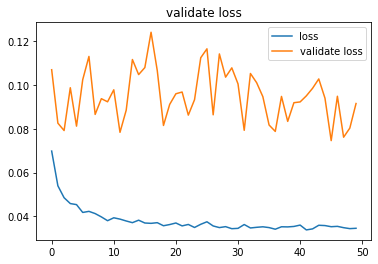

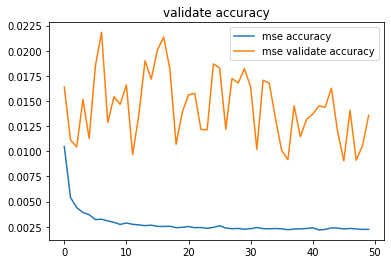

In [0]:
# feed_forward
model_ff = create_model_ff(N_VARS, N_DAYS)
history_ff = model_ff.fit(x_train, y_train,
                            epochs = N_EPOCH,
                            batch_size = N_DAYS,
                            validation_data = (x_val, y_val),
                            verbose = 0)
#plt.ylim(0.12, 0.35)
plt.plot(history_ff.history['loss'], label='loss')
plt.plot(history_ff.history['val_loss'], label='validate loss')
plt.legend()
plt.title('validate loss')
plt.show()

#plt.ylim(0.01, 0.18)
plt.plot(history_ff.history['mse'], label='mse accuracy')
plt.plot(history_ff.history['val_mse'], label='mse validate accuracy')
plt.legend()
plt.title('validate accuracy')
plt.show()

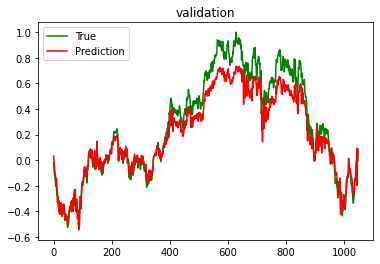

In [0]:
# VALIDATION
results_ff = model_ff.predict(x_val)
plt.plot(range(len(y_val)), y_val, c='g', label='True')
plt.plot(range(len(results_ff)), results_ff, c='r', label='Prediction')
plt.legend()
plt.title('validation')
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 120)         58080     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120)               86880     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

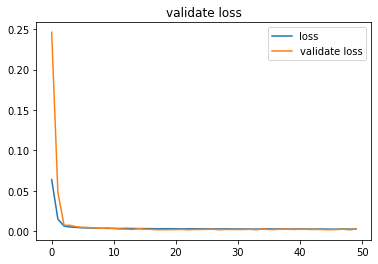

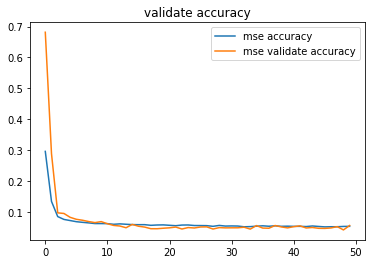

In [0]:
model_lstm = create_model_lstm(
                          sequence_length = N_DAYS * N_VARS, # Window size or the sequence length
                          loss = "huber_loss", 
                          units = N_DAYS * N_VARS, # LSTM neurons
                          cell = LSTM, 
                          n_layers = 3, 
                          dropout = 0.4, 
                          optimizer = "adam", 
                          bidirectional = True)

# some tensorflow callbacks
# callbacks=[checkpointer, tensorboard],
#checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
#tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history_lstm = model_lstm.fit(x_train, y_train,
                              batch_size = 128,
                              epochs = N_EPOCH,
                              validation_data = (x_val,y_val),
                              verbose = 0)
#plt.ylim(0.12, 0.35)
plt.plot(history_lstm.history['loss'], label='loss')
plt.plot(history_lstm.history['val_loss'], label='validate loss')
plt.legend()
plt.title('validate loss')
plt.show()

#plt.ylim(0.01, 0.18)
plt.plot(history_lstm.history['mean_absolute_error'], label='mse accuracy')
plt.plot(history_lstm.history['val_mean_absolute_error'], label='mse validate accuracy')
plt.legend()
plt.title('validate accuracy')
plt.show()

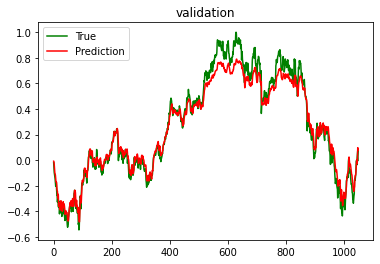

In [0]:
# VALIDATION
results_lstm = model_lstm.predict(x_val)
plt.plot(range(len(y_val)), y_val, c='g', label='True')
plt.plot(range(len(results_lstm)), results_lstm, c='r', label='Prediction')
plt.legend()
plt.title('validation')
plt.show()

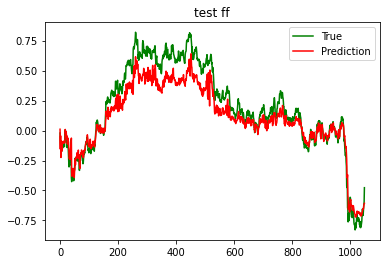

In [0]:
# TEST
results_ff = model_ff.predict(x_test)
plt.plot(range(len(y_test)), y_test, c='g', label='True')
plt.plot(range(len(results_ff)), results_ff, c='r', label='Prediction')
plt.legend()
plt.title('test ff')
plt.show()

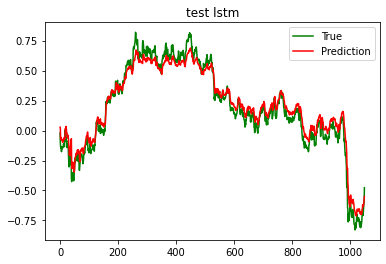

In [0]:
# TEST
results_lstm = model_lstm.predict(x_test)
plt.plot(range(len(y_test)), y_test, c='g', label='True')
plt.plot(range(len(results_lstm)), results_lstm, c='r', label='Prediction')
plt.legend()
plt.title('test lstm')
plt.show()